In [51]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

from sklearn.metrics import mean_squared_error

In [52]:
import pandas as pd
path2csv = './database/metadata.csv'
df = pd.read_csv(path2csv)
dir_list = []
for i in range(len(df)):
    dir_list.append('./'+df['directory'][i])
df.drop(['name','index'], axis=1, inplace=True)
#df.drop(['a','v'], axis=1, inplace=True)
df.tail(3)

,directory,heat,weight,colorfulness,saturation,brightness,pleasure,dominance,horizontal_intensity,vertical_intensity,...,waveletAV,waveletAD,waveletBH,waveletBV,waveletBD,vertical_similarity,horizontal_similarity,ruleOfThirds,a,v
54,database/painting/055.jpg,0.502064,1.075300,28.727802,0.465279,0.530236,0.468224,-0.254090,0.695328,0.099177,...,-0.000355,0.000574,-0.435728,-0.000355,-0.000574,0.980298,0.962079,0.964504,6.287000,6.471000
55,database/painting/056.jpg,-0.797139,-0.927580,32.892406,0.508540,0.548231,0.490158,-0.253923,0.000000,0.557676,...,-0.000109,0.001425,0.001237,0.001902,-0.001425,0.955615,0.962532,0.956674,3.582333,5.574667
56,database/painting/057.jpg,1.237772,0.727806,18.670452,0.353079,0.585810,0.481887,-0.332231,2.961220,0.489046,...,0.000000,0.000000,-0.233711,0.000000,0.000000,0.970833,0.958790,0.963362,5.919833,7.268000


In [53]:
from PIL import Image
import torch
from torch.utils.data import Dataset

# fix torch random seed
torch.manual_seed(0)

In [54]:
from PIL import Image

class paintingDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.root_dir = './database/painting'
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = './' + self.metadata.iloc[idx, 0]
        image = Image.open(img_name)
        feature = self.metadata.iloc[idx,-2:]
        feature = np.array([feature])
        feature = feature.astype('float').reshape(-1)
        
        #sample = {'image': image, 'feature': feature}
        
        if self.transform is not None:
            image = self.transform(image)

        return image, feature

In [55]:
train_rate = 0.7
num = round(train_rate * len(df))
train_dataset = paintingDataset(df[:num],transform=transforms.Compose([
                                               transforms.Resize(256),
                                               transforms.RandomCrop(224),
                                               transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ]))

test_dataset = paintingDataset(df[num:],transform=transforms.Compose([
                                               transforms.Resize(256),
                                               transforms.RandomCrop(224),
                                               transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ]))

In [56]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=4, 
                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=4, 
                                             shuffle=False)

torch.Size([4, 3, 224, 224])


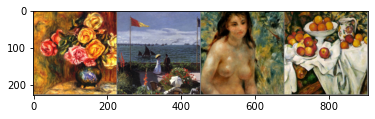

tensor([[1.3910, 4.1495],
        [5.9040, 2.8850],
        [5.0920, 3.4830],
        [3.9040, 3.1302]], dtype=torch.float64)


In [57]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, features = dataiter.next()
print(images.size())
imshow(torchvision.utils.make_grid(images))
print(features)

In [67]:
from model.resnet import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)

num_epochs = 200
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.00001)

In [68]:
import torchsummary
net = model
torchsummary.summary(net, (3, 224, 224), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 112, 112]           9,408
       BatchNorm2d-2          [4, 64, 112, 112]             128
              ReLU-3          [4, 64, 112, 112]               0
         MaxPool2d-4            [4, 64, 56, 56]               0
            Conv2d-5            [4, 64, 56, 56]           4,096
       BatchNorm2d-6            [4, 64, 56, 56]             128
              ReLU-7            [4, 64, 56, 56]               0
            Conv2d-8            [4, 64, 56, 56]          36,864
       BatchNorm2d-9            [4, 64, 56, 56]             128
             ReLU-10            [4, 64, 56, 56]               0
           Conv2d-11           [4, 256, 56, 56]          16,384
      BatchNorm2d-12           [4, 256, 56, 56]             512
           Conv2d-13           [4, 256, 56, 56]          16,384
      BatchNorm2d-14           [4, 256,

In [69]:
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    
    model.train()
    for data in train_loader:
        inputs, gt = data[0].to(device), data[1].to(device)
        
        opt.zero_grad()
        av = model(inputs)
        loss = loss_func(av, gt.float())
        loss.backward()
        
        opt.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)
    
    model.eval() 
    with torch.no_grad():
        test_loss = 0.0
        for data in test_loader:
            inputs, gt = data[0].to(device), data[1].to(device)
            av = model(inputs)
            loss = loss_func(av, gt.float())
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        test_loss_list.append(test_loss)


    print('[epoch %d] Train loss: %.3f, Test loss: %.3f' %(epoch, train_loss, test_loss))
    print(testing(model))#a_mse, v_mse = testing(model)[0], testing(model)[1]
    #print('test a_mse %.3f, v_mse %.3f' %(a_mse, v_mse))

[epoch 0] Train loss: 18.165, Test loss: 31.233
(13.200733488418603, 18.00716157791547)
[epoch 1] Train loss: 16.196, Test loss: 29.986
(12.528248987095502, 17.445009385711067)
[epoch 2] Train loss: 14.612, Test loss: 28.570
(12.008633215538662, 16.57641471295661)
[epoch 3] Train loss: 12.938, Test loss: 26.490
(10.912721780289832, 15.35012188577179)
[epoch 4] Train loss: 11.775, Test loss: 23.624
(9.783986335446231, 13.813478543597114)
[epoch 5] Train loss: 10.158, Test loss: 20.426
(8.459232770134765, 12.167925007235128)
[epoch 6] Train loss: 9.111, Test loss: 18.080
(7.09769581292227, 10.766873484361533)
[epoch 7] Train loss: 8.145, Test loss: 15.853
(5.868288560586185, 9.656615348309803)
[epoch 8] Train loss: 7.182, Test loss: 13.975
(5.189767407090896, 8.82012117506208)
[epoch 9] Train loss: 6.342, Test loss: 12.628
(4.773040980382774, 7.658771972213126)
[epoch 10] Train loss: 5.640, Test loss: 11.479
(4.279349017561574, 7.010258110715401)
[epoch 11] Train loss: 5.198, Test loss: 

[epoch 94] Train loss: 1.760, Test loss: 3.114
(0.9535819373918205, 2.1512475145292616)
[epoch 95] Train loss: 1.696, Test loss: 3.155
(1.0032101050155358, 2.128768123581866)
[epoch 96] Train loss: 1.671, Test loss: 3.125
(1.0493826028031719, 1.9480393258966877)
[epoch 97] Train loss: 1.789, Test loss: 3.077
(1.0466004753414968, 2.3015323466615683)
[epoch 98] Train loss: 1.842, Test loss: 3.078
(0.9884675398479938, 2.067421443466656)
[epoch 99] Train loss: 1.649, Test loss: 3.442
(0.9952398821715519, 2.0565030145893504)
[epoch 100] Train loss: 1.956, Test loss: 2.863
(1.0007174986912388, 2.3921977415599662)
[epoch 101] Train loss: 1.631, Test loss: 3.407
(0.9852274147548238, 2.2045447870392474)
[epoch 102] Train loss: 1.988, Test loss: 3.669
(1.1091343813000436, 2.7411331987554215)
[epoch 103] Train loss: 1.644, Test loss: 3.228
(1.0760987758778857, 2.021684295188635)
[epoch 104] Train loss: 1.661, Test loss: 2.988
(1.1835820272172781, 1.8740233326351443)
[epoch 105] Train loss: 1.718,

KeyboardInterrupt: 

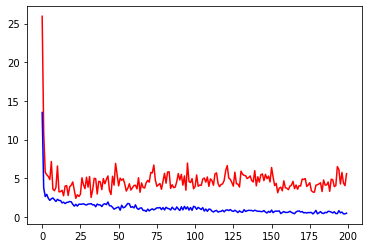

In [61]:
plt.plot(test_loss_list, c='r')
plt.plot(train_loss_list, c='b')

In [64]:
def testing(model):
    with torch.no_grad():
        a_temp = 0.0
        v_temp = 0.0
        for data in test_loader:
            model = model.to(device)
            model = model.eval()

            inputs, gt = data[0].to(device), data[1].to(device)
            output = model(inputs)

            #print(mean_squared_error(output.cpu(), gt.cpu()))
            #print(output[:,0])
            a_temp += mean_squared_error(output[:,0].cpu(), gt[:,0].cpu())
            v_temp += mean_squared_error(output[:,1].cpu(), gt[:,1].cpu())
        A_MSE = a_temp / len(train_loader)
        V_MSE = v_temp / len(train_loader)
    return A_MSE, V_MSE

In [65]:
testing(model)

(2.050062391190154, 4.040929342247909)